### Random Forest Prototype
This file uses the insights gathered in the capstone_ml_prototype pipeline to fit a hyperparameter-tuned random forest to the test set to compare accuracy scores across the training and test sets (we use the validation set as the test set, as the test set is not labelled).

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
#from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
#Load and split the data
training_data = pd.read_csv("train.csv")
testing_data = pd.read_csv("test.csv")
costa_rica_data = training_data.drop(['Target'], axis=1)
costa_rica_target = training_data['Target']

#Clean the data to either replace or remove string columns
costa_rica_data.select_dtypes(exclude=[np.number]).head()
costa_rica_data = costa_rica_data.select_dtypes(include=[np.number], exclude=[np.object]).fillna(0)

#Split data into 80% train, 20% validation split
X_train, X_test, y_train, y_test = train_test_split(costa_rica_data.values, costa_rica_target.values, test_size= 0.2, random_state=42)

In [3]:
#Fit a Decision Tree with default parameters to get a baseline idea of performance
clf = RandomForestClassifier(random_state=42)
model = clf.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)
print('Random Forest Train Accuracy: '+str(round(train_score*100,2))+'%')
print('Random Forest Test Accuracy: '+str(round(test_score*100,2))+'%')

Random Forest Train Accuracy: 99.74%
Random Forest Test Accuracy: 90.79%


/Users/krishi/Library/Python/2.7/lib/python/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



Random Forest
Accuracy on training set: 1.000
Accuracy on test set: 0.924

Random Forest Feature Importance


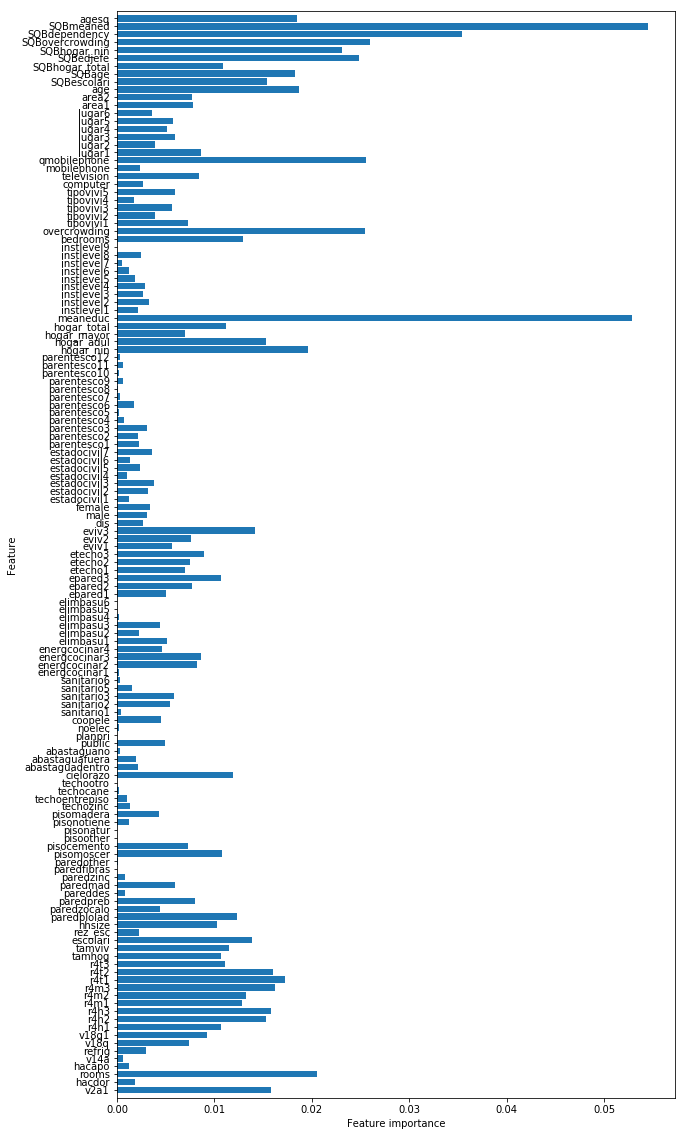

In [4]:
#Run Feature Importance to extract relevant features
X_train_features = [x for i,x in enumerate(list(costa_rica_data.columns))]

def plot_feature_importances_costa(model):
    plt.figure(figsize=(10,20))
    n_features = len(list(costa_rica_data.columns))
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), X_train_features)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
    plt.show()

rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)
print("")
print('Random Forest')
print("Accuracy on training set: {:.3f}".format(rf.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(rf.score(X_test, y_test)))

print("")
print('Random Forest Feature Importance')
plot_feature_importances_costa(rf)

Feature ranking:
1. feature 98 (0.053438)
2. feature 135 (0.052117)
3. feature 134 (0.035147)
4. feature 131 (0.025651)
5. feature 118 (0.025495)
6. feature 133 (0.025383)
7. feature 109 (0.025274)
8. feature 132 (0.021411)
9. feature 94 (0.020985)
10. feature 2 (0.020294)


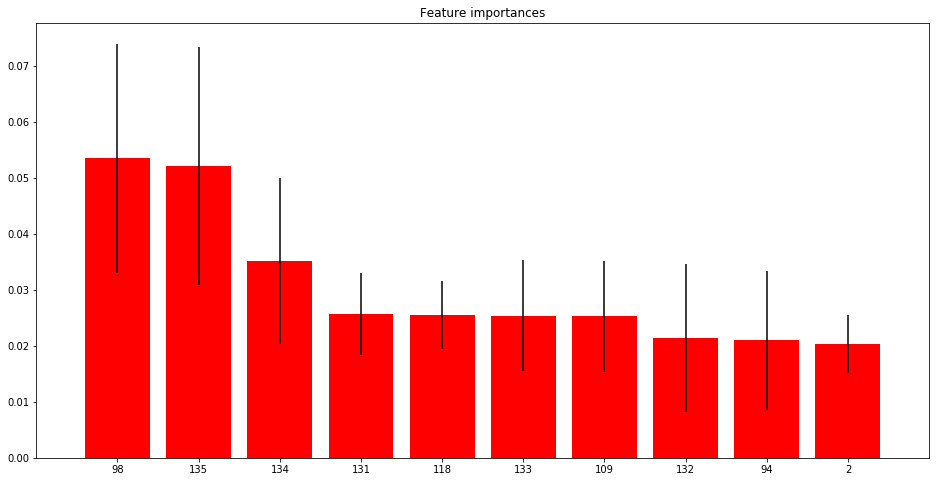

In [5]:
# Build a forest and compute the feature importances
forest = RandomForestClassifier(n_estimators=250,
                              random_state=0)

n_features = 10
forest.fit(X_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(n_features):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(16,8))
plt.title("Feature importances")
plt.bar(range(n_features), importances[indices][:n_features],
       color="r", yerr=std[indices][:n_features], align="center")
plt.xticks(range(n_features), indices)
plt.xlim([-1, n_features])
plt.show()

In [6]:
#Extract feature names
cols = costa_rica_data.columns.values
dicts = dict(zip(cols, range(len(cols))))

features = []
for key in dicts:
    if dicts[key] in [98, 135, 134, 131, 118, 133, 109, 132, 94, 2]:
        features.append(key)

In [7]:
#Optimize hyperparameters of a Random Forest model using Grid Search in Python
def optimizeParameter():

    import warnings
    warnings.filterwarnings("ignore")

    # load libraries
    from sklearn import decomposition, datasets
    from sklearn import tree
    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import GridSearchCV, cross_val_score
    from sklearn.preprocessing import StandardScaler

    # Load the data
    X_train = costa_rica_data.values
    y_train = costa_rica_target.values

    # Create an scaler object
    sc = StandardScaler()

    # Create a logistic regression object with an L2 penalty
    decisiontree = RandomForestClassifier()

    # Create a pipeline of three steps. First, standardize the data.
    # Second, tranform the data with PCA.
    # Third, train a Decision Tree Classifier on the data.
    pipe = Pipeline(steps=[('sc', sc),
                           ('decisiontree', decisiontree)])

    # Create lists of parameter for Decision Tree Classifier
    criterion = ['gini', 'entropy']
    max_depth = [35, 50, 65, 70, 75, 90]

    # Create a dictionary of all the parameter options 
    # Note has you can access the parameters of steps of a pipeline by using '__’
    parameters = dict(decisiontree__criterion=criterion,
                      decisiontree__max_depth=max_depth)

    # Conduct Parameter Optmization With Pipeline
    # Create a grid search object
    clf = GridSearchCV(pipe, parameters)

    # Fit the grid search
    clf.fit(X_train, y_train)

    # View The Best Parameters
    print('Best Criterion:', clf.best_estimator_.get_params()['decisiontree__criterion'])
    print('Best max_depth:', clf.best_estimator_.get_params()['decisiontree__max_depth'])
    print(); print(clf.best_estimator_.get_params()['decisiontree'])

    # Use Cross Validation To Evaluate Model
    CV_Result = cross_val_score(clf, X_train, y_train, cv=4, n_jobs=-1)
    print(); print(CV_Result)
    print(); print(CV_Result.mean())
    print(); print(CV_Result.std())

optimizeParameter()

('Best Criterion:', 'entropy')
('Best max_depth:', 70)
()
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=70, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
()
[ 0.66039314  0.62829636  0.54750942  0.47822446]
()
0.578605843258
()
0.0710663774023


In [9]:
#Fit Decision Tree with these most important features
X_train, X_test, y_train, y_test = train_test_split(costa_rica_data[features].values, costa_rica_target.values, test_size= 0.2, random_state=42)
clf = RandomForestClassifier(criterion='entropy', max_depth=70)
model = clf.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
train_score = model.score(X_train, y_train)
val_score = model.score(X_test, y_test)
print('Random Forest Train Accuracy: '+str(round(train_score*100,2))+'%')
print('Random Forest Validation Accuracy: '+str(round(val_score*100,2))+'%')

Random Forest Train Accuracy: 96.43%
Random Forest Validation Accuracy: 92.42%


### Model Results
We can see that our model's train and validation accuracy are close together. However, the Random Forest did not perform as strongly as the decision tree. Since our test set does not have labels, we cannot use that to further corroborate our model.